# STUDY HOURS ESTIMATOR

# Problem Description:
```
The objective of this project is to create a machine learning model that predicts the total number of study hours a student may need to prepare for a particular topic or course. Using general features such as target exam score, sleep hours, motivation level, and access to resources, the model will predict the number of studying required and the result will be processed and categorized into predefined categories(e.g., 5-10 hours, 10-15 hours, 15-20 hours, etc.). This is a regression task aimed at helping students plan their study schedules by providing time estimates that align with their individual learning needs, habits, and current circumstances.
```

### About the Dataset:
```
Sourced from: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors
Provenance: The "Student Performance Factors" dataset is a synthetic dataset generated for educational and analytical purposes. The data is not sourced from any real-world institutions but is created to simulate realistic scenarios for analyzing student performance factors.
```

In [212]:
import numpy as np
import pandas as pd

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

# for features
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# saving/loading
import pickle

df = pd.read_csv('../study-dataset/StudentPerformanceFactors.csv')
df.head().T

,0,1,2,3,4
Hours_Studied,23,19,24,29,19
Attendance,84,64,98,89,92
Parental_Involvement,Low,Low,Medium,Low,Medium
Access_to_Resources,High,Medium,Medium,Medium,Medium
Extracurricular_Activities,No,No,Yes,Yes,Yes
Sleep_Hours,7,8,7,8,6
Previous_Scores,73,59,91,98,65
Motivation_Level,Low,Low,Medium,Medium,Medium
Internet_Access,Yes,Yes,Yes,Yes,Yes
Tutoring_Sessions,0,2,2,1,3


# Data Preparation

In [213]:
# column names to lowercase
df.columns = df.columns.str.lower()

cat_variables = df.select_dtypes('object').columns

# make values uniform
for column_name in cat_variables:
    df[column_name] = df[column_name].str.lower().str.replace(' ', '_')

In [214]:
ordinal_order = ['low', 'medium', 'high']
ordinal_data = ['parental_involvement', 'access_to_resources', 'family_income', 'teacher_quality', 'motivation_level']

for cols in ordinal_data:
    df[cols] = pd.Categorical(df[cols], categories=ordinal_order, ordered=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   hours_studied               6607 non-null   int64   
 1   attendance                  6607 non-null   int64   
 2   parental_involvement        6607 non-null   category
 3   access_to_resources         6607 non-null   category
 4   extracurricular_activities  6607 non-null   object  
 5   sleep_hours                 6607 non-null   int64   
 6   previous_scores             6607 non-null   int64   
 7   motivation_level            6607 non-null   category
 8   internet_access             6607 non-null   object  
 9   tutoring_sessions           6607 non-null   int64   
 10  family_income               6607 non-null   category
 11  teacher_quality             6529 non-null   category
 12  school_type                 6607 non-null   object  
 13  peer_influence    

### Missing Values

In [215]:
df.isnull().any()

hours_studied                 False
attendance                    False
parental_involvement          False
access_to_resources           False
extracurricular_activities    False
sleep_hours                   False
previous_scores               False
motivation_level              False
internet_access               False
tutoring_sessions             False
family_income                 False
teacher_quality                True
school_type                   False
peer_influence                False
physical_activity             False
learning_disabilities         False
parental_education_level       True
distance_from_home             True
gender                        False
exam_score                    False
dtype: bool

In [216]:
# drop the rows containing null values
df.dropna(inplace=True)

In [311]:
y = df['hours_studied'].values

# split data 80 20 (splitting another 20 from 80 later)
df_full_train, df_test, y_full, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
print(len(df_full_train), len(y_full))

5102 5102


# EDA

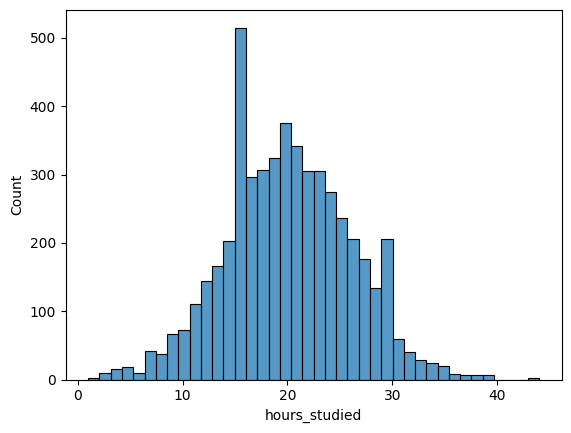

In [313]:
sns.histplot(df_full_train.hours_studied, bins=40)
plt.show()

This is a normal distribution. There is no need to perform transformation.

In [314]:
df_full_train.describe()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
count,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000,5102.000000
mean,20.067817,80.086241,7.030380,74.977068,1.490396,2.973148,67.296354
std,6.001936,11.570806,1.459261,14.368019,1.224547,1.033579,3.980789
min,1.000000,60.000000,4.000000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,87.000000,2.000000,4.000000,70.000000
max,44.000000,100.000000,10.000000,100.000000,8.000000,6.000000,101.000000


In [315]:
numerical_cols = df_full_train.select_dtypes('number').columns
df_full_train[numerical_cols].corr()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
hours_studied,1.000000,0.003264,0.011225,0.023947,-0.022237,0.002601,0.441340
attendance,0.003264,1.000000,-0.016735,-0.015721,0.010684,-0.028034,0.575227
sleep_hours,0.011225,-0.016735,1.000000,-0.021463,-0.013605,-0.010507,-0.017209
previous_scores,0.023947,-0.015721,-0.021463,1.000000,-0.012074,-0.007051,0.170867
tutoring_sessions,-0.022237,0.010684,-0.013605,-0.012074,1.000000,0.018615,0.143834
physical_activity,0.002601,-0.028034,-0.010507,-0.007051,0.018615,1.000000,0.016610
exam_score,0.441340,0.575227,-0.017209,0.170867,0.143834,0.016610,1.000000


## Numerical Variables

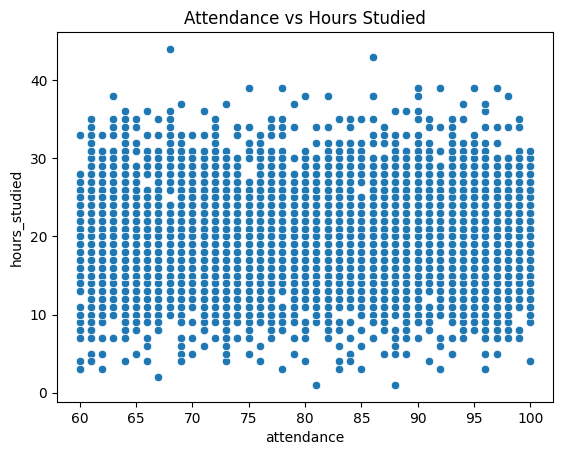

In [316]:
sns.scatterplot(x=df_full_train['attendance'], y=df_full_train['hours_studied'])
plt.title('Attendance vs Hours Studied');

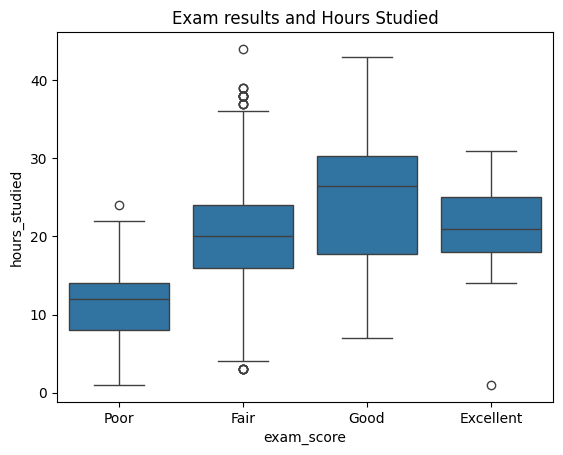

In [317]:
# i decided to categorize the exam scores in 4 categories
bins = [50, 60, 75, 90, 100]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_exams_cat = pd.cut(df_full_train['exam_score'], bins=bins, labels=labels)
sns.boxplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

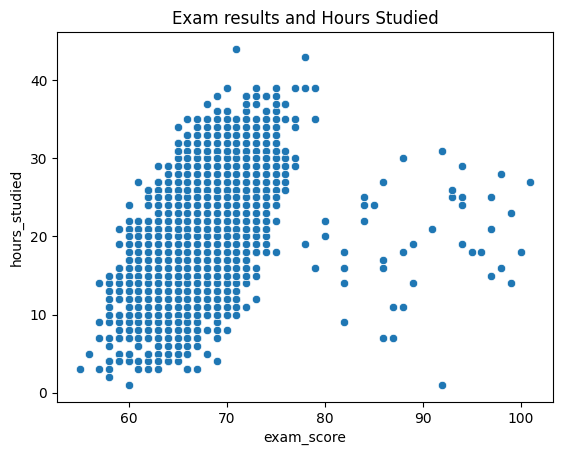

In [318]:
sns.scatterplot(x=df_full_train['exam_score'], y=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

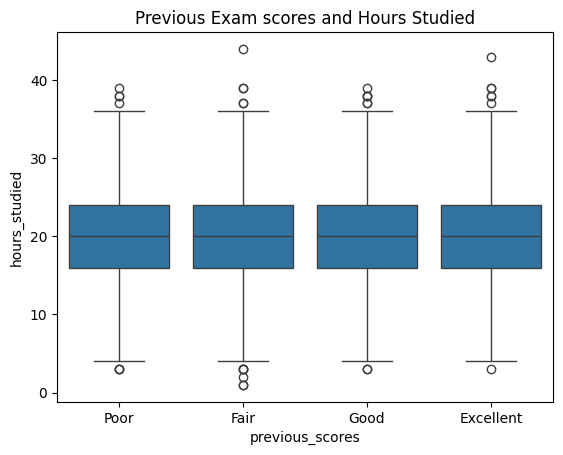

In [319]:
# i decided to categorize the exam scores in 4 categories
bins = [50, 60, 75, 90, 100]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_exams_cat = pd.cut(df_full_train['previous_scores'], bins=bins, labels=labels)
sns.boxplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Previous Exam scores and Hours Studied');

It seems that previous exam scores did not affect the total hours studied.

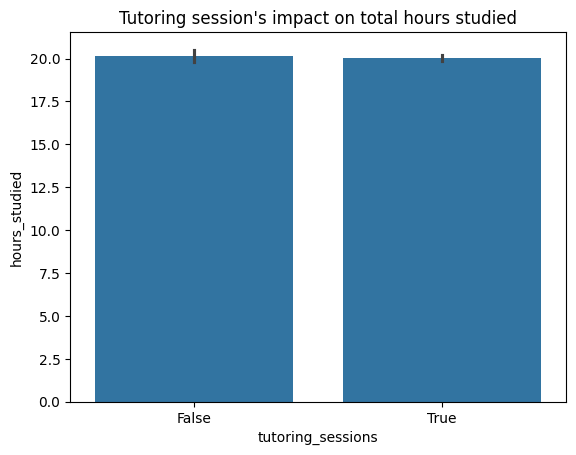

In [320]:
df_exams_cat = (df_full_train['tutoring_sessions'] != 0)
sns.barplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Tutoring session\'s impact on total hours studied');

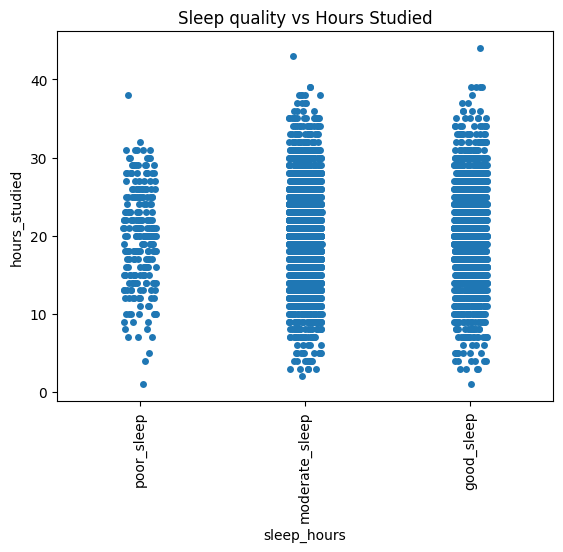

In [321]:
bins = [0, 4, 7, 10]
labels = ['poor_sleep', 'moderate_sleep', 'good_sleep']
df_exams_cat = pd.cut(df_full_train['sleep_hours'], bins=bins, labels=labels)
sns.stripplot(x=df_exams_cat, y=df_full_train['hours_studied'])
plt.title('Sleep quality vs Hours Studied')
plt.xticks(rotation=90);

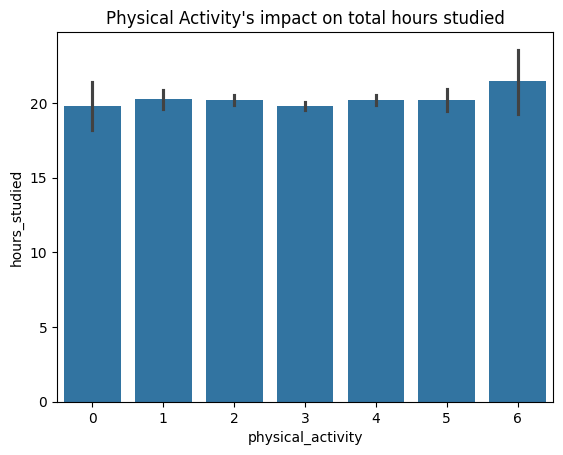

In [322]:
sns.barplot(x=df_full_train['physical_activity'], y=df_full_train['hours_studied'])
plt.title('Physical Activity\'s impact on total hours studied');

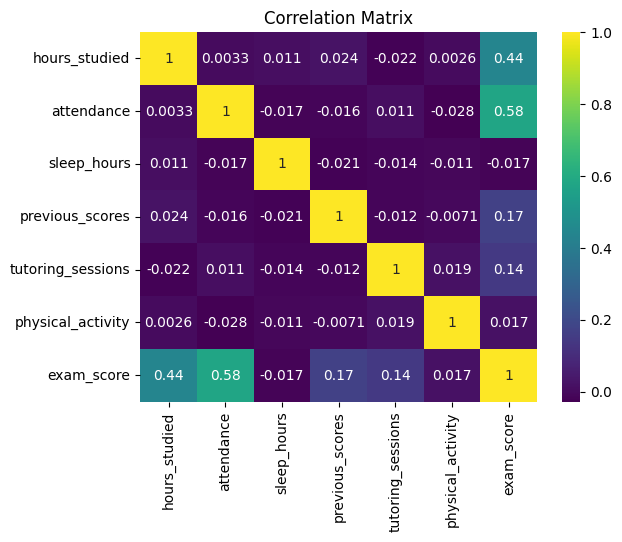

In [323]:
corr_matrix = df_full_train[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

*exam_score* shows moderate correlation with *hours_studied*. The rest have very low correlation.

### Outlier adjustments

In [324]:
# extract the outliers from exam_score(a moderately correlated feature to hours studied)
Q1 = df_full_train['exam_score'].quantile(0.25)
Q3 = df_full_train['exam_score'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df_full_train['exam_score'] < (Q1 - 1.5 * IQR)) | (df_full_train['exam_score'] > (Q3 + 1.5 * IQR))
outliers = df_full_train[outlier_condition]
# handle outlier using median
median_score = df_full_train['exam_score'].median()
df_full_train.loc[outlier_condition, 'exam_score'] = median_score

In [325]:
len(df_full_train), len(y_full)

(5102, 5102)

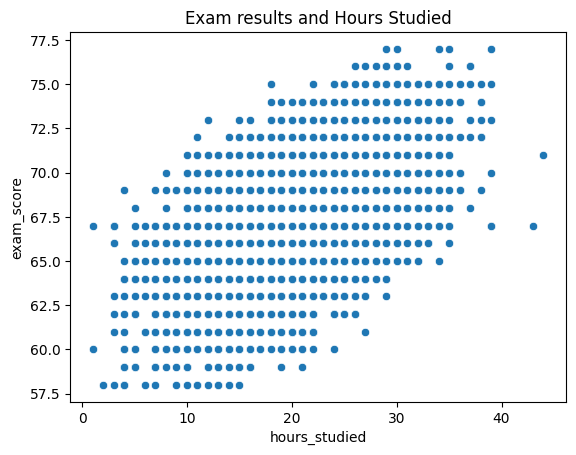

In [326]:
sns.scatterplot(y=df_full_train['exam_score'], x=df_full_train['hours_studied'])
plt.title('Exam results and Hours Studied');

## Categorical Variables

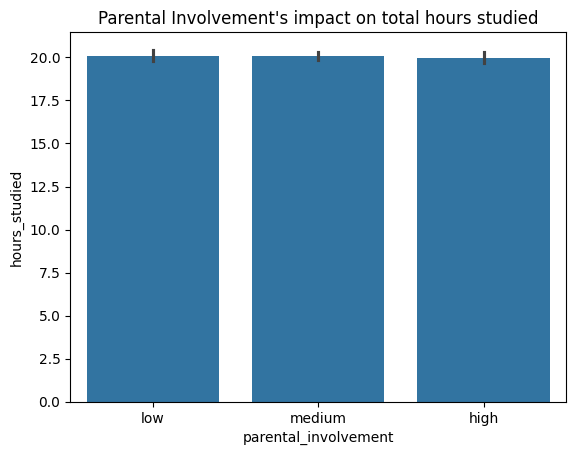

In [327]:
sns.barplot(x=df_full_train['parental_involvement'], y=df_full_train['hours_studied'])
plt.title('Parental Involvement\'s impact on total hours studied');

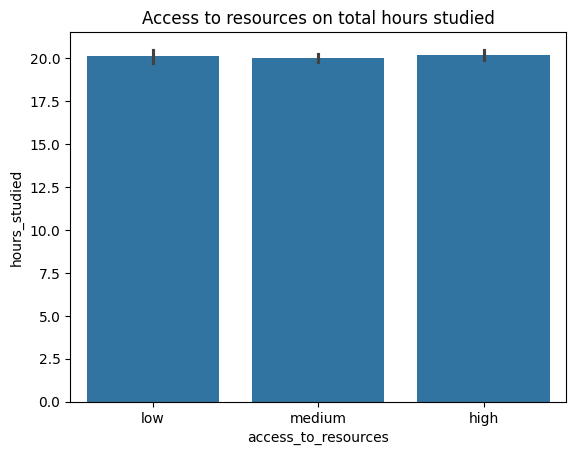

In [328]:
sns.barplot(x=df_full_train['access_to_resources'], y=df_full_train['hours_studied'])
plt.title('Access to resources on total hours studied');

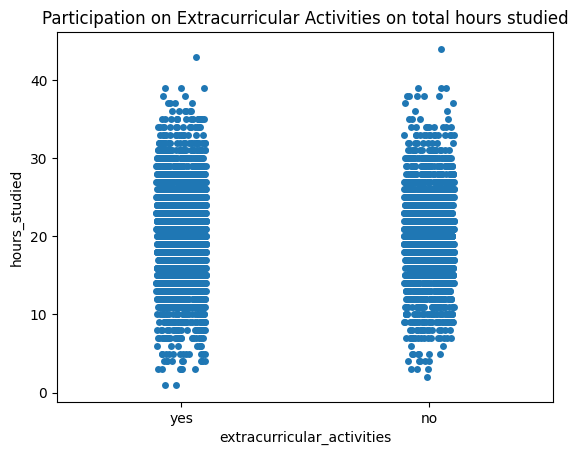

In [329]:
sns.stripplot(x=df_full_train['extracurricular_activities'], y=df_full_train['hours_studied'])
plt.title('Participation on Extracurricular Activities on total hours studied');

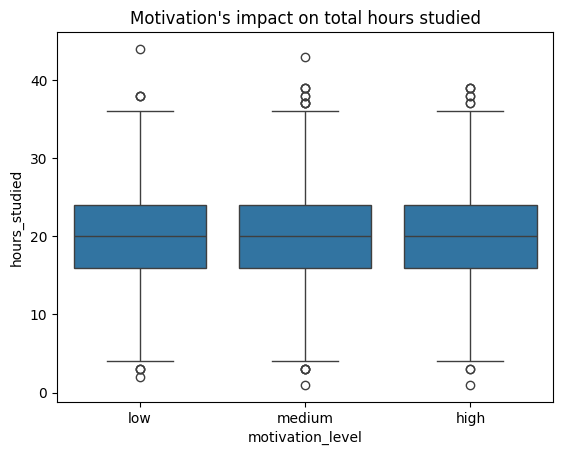

In [330]:
sns.boxplot(x=df_full_train['motivation_level'], y=df_full_train['hours_studied'])
plt.title('Motivation\'s impact on total hours studied');

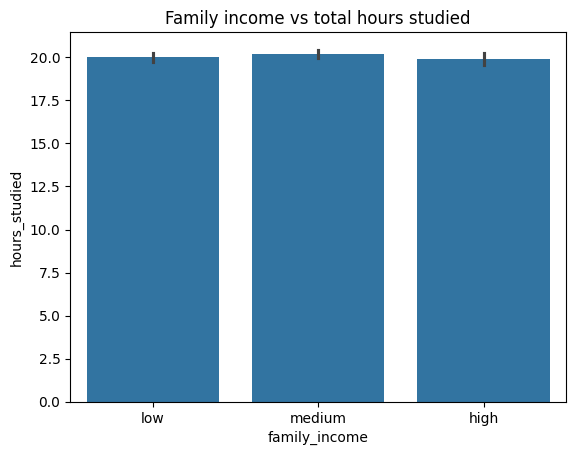

In [331]:
sns.barplot(x=df_full_train['family_income'], y=df_full_train['hours_studied'])
plt.title('Family income vs total hours studied');

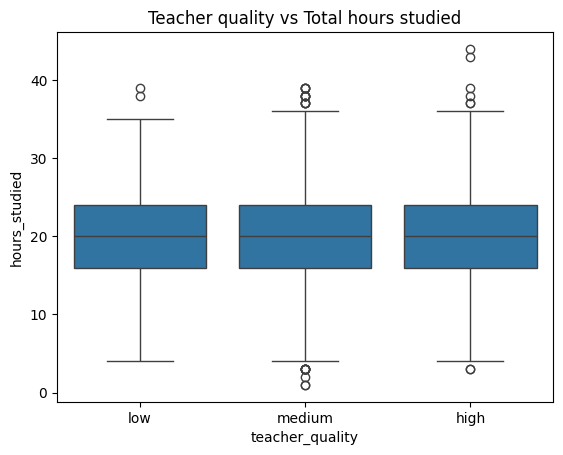

In [332]:
sns.boxplot(x=df_full_train['teacher_quality'], y=df_full_train['hours_studied'])
plt.title('Teacher quality vs Total hours studied');

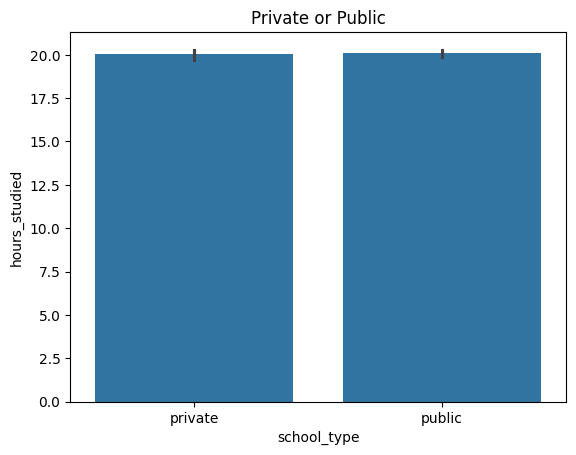

In [333]:
sns.barplot(x=df_full_train['school_type'], y=df_full_train['hours_studied'])
plt.title('Private or Public');

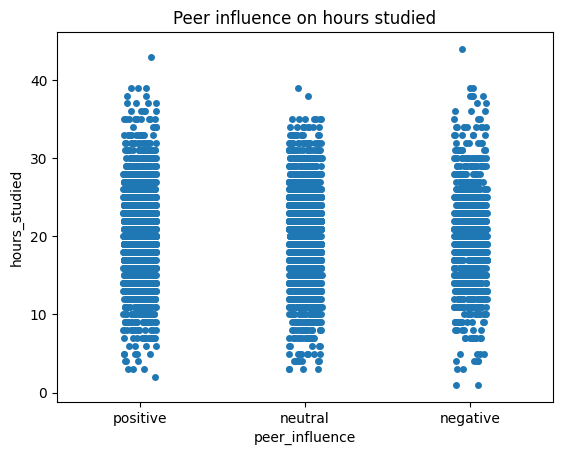

In [334]:
sns.stripplot(x=df_full_train['peer_influence'], y=df_full_train['hours_studied'])
plt.title('Peer influence on hours studied');

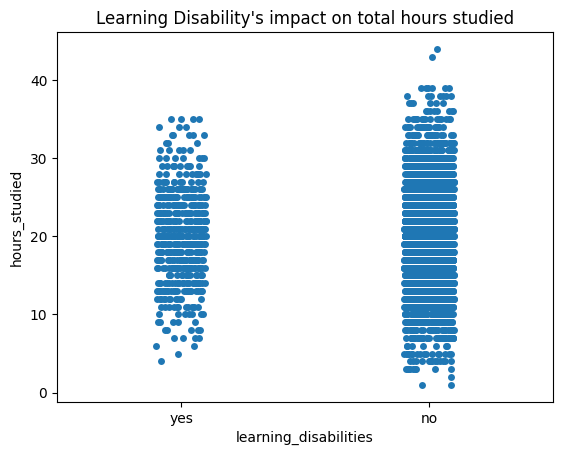

In [335]:
sns.stripplot(x=df_full_train['learning_disabilities'], y=df_full_train['hours_studied'])
plt.title('Learning Disability\'s impact on total hours studied');

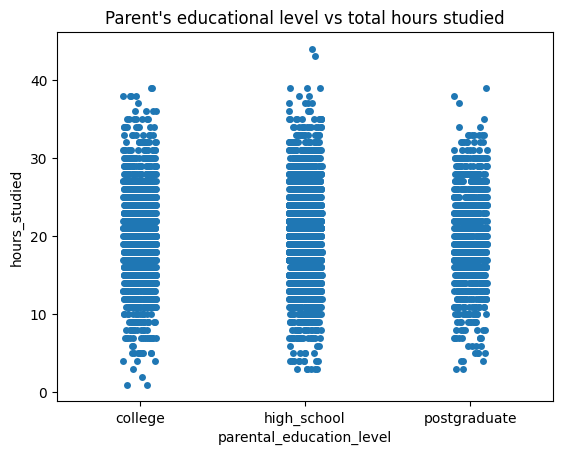

In [336]:
sns.stripplot(x=df_full_train['parental_education_level'], y=df_full_train['hours_studied'])
plt.title('Parent\'s educational level vs total hours studied');

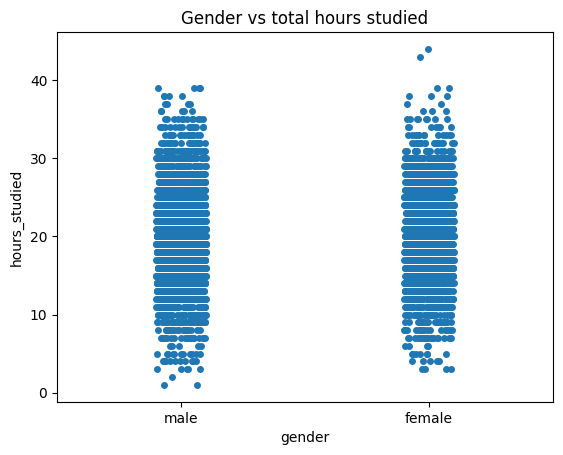

In [337]:
sns.stripplot(x=df_full_train['gender'], y=df_full_train['hours_studied'])
plt.title('Gender vs total hours studied');

There's barely any useful information from these features associated with the number of hours studied.

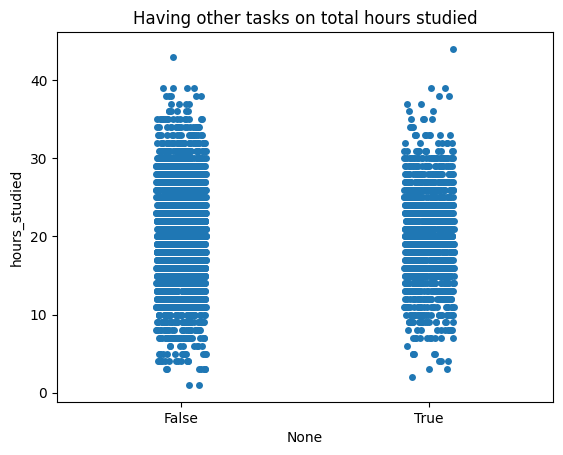

In [338]:
sns.stripplot(x=((df_full_train['physical_activity'] <= 3) & (df_full_train['extracurricular_activities'] == 'no')), y=df_full_train['hours_studied'])
plt.title('Having other tasks on total hours studied'); 

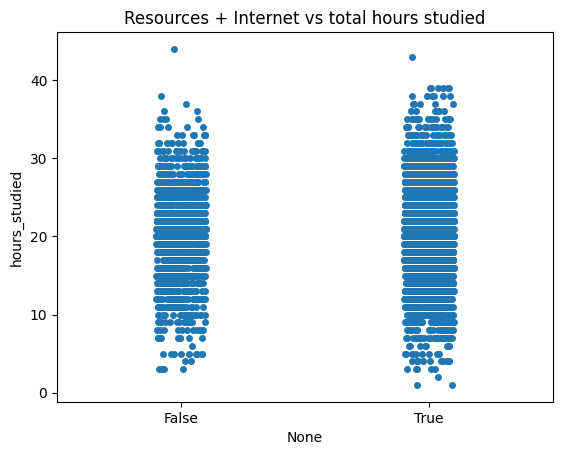

In [339]:
sns.stripplot(x=((df_full_train['access_to_resources'] != 'low') & (df_full_train['internet_access'] == 'yes')), y=df_full_train['hours_studied'])
plt.title('Resources + Internet vs total hours studied'); 

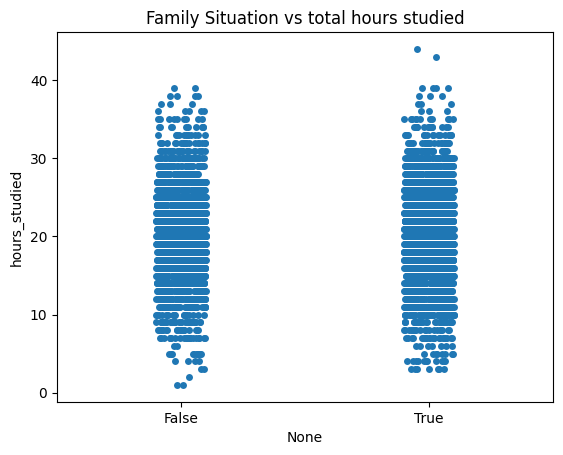

In [340]:
sns.stripplot(x=((df_full_train['family_income'] != 'high') & (df_full_train['parental_education_level'] != 'college')), y=df_full_train['hours_studied'])
plt.title('Family Situation vs total hours studied'); 

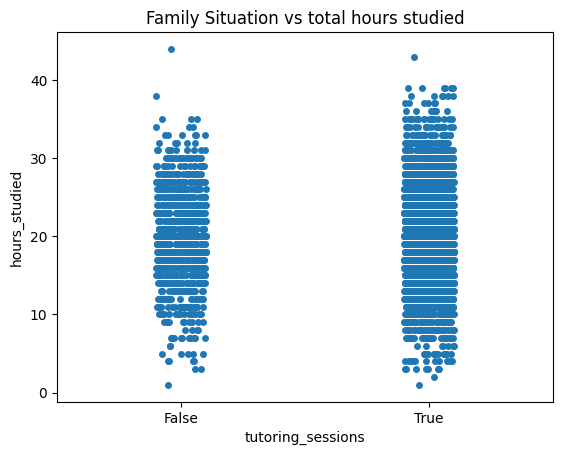

In [341]:
sns.stripplot(x=((df_full_train['tutoring_sessions'] <= 2)), y=df_full_train['hours_studied'])
plt.title('Family Situation vs total hours studied'); 

# Feature Engineering

In [345]:
del df_full_train['hours_studied']
del df_test['hours_studied']
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full, test_size=len(df_test), random_state=1)

### One-hot encoding

In [353]:
dv = DictVectorizer(sparse=False)
# convert df to dictionary for dictvectorizer
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
# fit dv
dv.fit(train_dict)
# perform one hot encoding
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

# Model

In [380]:
# train the regression model
params = {
    "eval_metric": "mae",              # mae for evaluation
    "learning_rate": 0.1,
    "max_depth": 5,
    "seed": 42
}

# train on validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	Validation-mae:4.52443
[10]	Validation-mae:3.49757
[20]	Validation-mae:3.14645
[30]	Validation-mae:2.92987
[40]	Validation-mae:2.77642
[50]	Validation-mae:2.61774
[60]	Validation-mae:2.49670
[70]	Validation-mae:2.39929
[80]	Validation-mae:2.31272
[90]	Validation-mae:2.24832
[100]	Validation-mae:2.18703
[110]	Validation-mae:2.13365
[120]	Validation-mae:2.08226
[130]	Validation-mae:2.03298
[140]	Validation-mae:1.99784
[150]	Validation-mae:1.96538
[160]	Validation-mae:1.93911
[170]	Validation-mae:1.91566
[180]	Validation-mae:1.89326
[190]	Validation-mae:1.87502
[200]	Validation-mae:1.85376
[210]	Validation-mae:1.83867
[220]	Validation-mae:1.82490
[230]	Validation-mae:1.81370
[240]	Validation-mae:1.80288
[250]	Validation-mae:1.78900
[260]	Validation-mae:1.77913
[270]	Validation-mae:1.76937
[280]	Validation-mae:1.76030
[290]	Validation-mae:1.75368
[300]	Validation-mae:1.74740
[310]	Validation-mae:1.74311
[320]	Validation-mae:1.73680
[330]	Validation-mae:1.73056
[340]	Validation-mae:1.72

In [381]:
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

full_dict = df_full_train.to_dict(orient='records')
X_full = dv.transform(full_dict)

# train on full
dtrain = xgb.DMatrix(X_full, label=y_full)
dval = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)

# predict
y_pred = model.predict(xgb.DMatrix(X_test))
# assign each prediction to the closest ordinal category
y_pred_cat = np.round(y_pred).astype(int)

# mae
mae = mean_absolute_error(y_test, y_pred)
print("Final Mean Absolute Error:", mae)

[0]	Validation-mae:4.52880
[10]	Validation-mae:3.49976
[20]	Validation-mae:3.14296
[30]	Validation-mae:2.92045
[40]	Validation-mae:2.74657
[50]	Validation-mae:2.58660
[60]	Validation-mae:2.45403
[70]	Validation-mae:2.34033
[80]	Validation-mae:2.24255
[90]	Validation-mae:2.16684
[100]	Validation-mae:2.09014
[110]	Validation-mae:2.02668
[120]	Validation-mae:1.97897
[130]	Validation-mae:1.92779
[140]	Validation-mae:1.88617
[150]	Validation-mae:1.85027
[160]	Validation-mae:1.81612
[170]	Validation-mae:1.78985
[180]	Validation-mae:1.76499
[190]	Validation-mae:1.73697
[200]	Validation-mae:1.71668
[210]	Validation-mae:1.69987
[220]	Validation-mae:1.68285
[230]	Validation-mae:1.66245
[240]	Validation-mae:1.64874
[250]	Validation-mae:1.64094
[260]	Validation-mae:1.62834
[270]	Validation-mae:1.62066
[280]	Validation-mae:1.61017
[290]	Validation-mae:1.60254
[300]	Validation-mae:1.59380
[310]	Validation-mae:1.58805
[320]	Validation-mae:1.57942
[330]	Validation-mae:1.57364
[340]	Validation-mae:1.56

I decided to make the range of estimation +-2. This would allow for more flexibility when it comes to time management as many other factors may affect the number of hours a student needs for studying. 

In [387]:
# for categorizing the target variable 'hours_studied'
def categorize_hours(hours):
    middle = np.round(hours)
    return (middle-2, middle+2)

predicted_cat = pd.Series(y_pred_cat).apply(categorize_hours)
actual_cat = pd.Series(y_test)
df_result = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_test,
    'predicted_cat': predicted_cat,
    'actual_cat': actual_cat
})
r2 = r2_score(actual_cat, y_pred_cat)
print(f'R-squared(R²) Score: {r2}')

R-squared(R²) Score: 0.8218952823235325


In [376]:
# function to check if an actual category falls within a predicted category
def is_within_range(actual, predicted):
    return predicted[0] <= actual <= predicted[1]

# calculate the accuracy
accuracy = df_result.apply(lambda row: is_within_range(row['actual_cat'], row['predicted_cat']), axis=1).mean()
r2 = r2_score(true_values, predicted_values)
print(&quot;R-squared (R²) Score:&quot;, r2)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8369905956112853


### Test on random Sample

In [377]:
df.loc[5].to_dict()

{'hours_studied': 19,
 'attendance': 88,
 'parental_involvement': 'medium',
 'access_to_resources': 'medium',
 'extracurricular_activities': 'yes',
 'sleep_hours': 8,
 'previous_scores': 89,
 'motivation_level': 'medium',
 'internet_access': 'yes',
 'tutoring_sessions': 3,
 'family_income': 'medium',
 'teacher_quality': 'medium',
 'school_type': 'public',
 'peer_influence': 'positive',
 'physical_activity': 3,
 'learning_disabilities': 'no',
 'parental_education_level': 'postgraduate',
 'distance_from_home': 'near',
 'gender': 'male',
 'exam_score': 71}

In [378]:
test_student = {'attendance': 88,
 'parental_involvement': 'medium',
 'access_to_resources': 'medium',
 'extracurricular_activities': 'yes',
 'sleep_hours': 8,
 'previous_scores': 89,
 'motivation_level': 'medium',
 'internet_access': 'yes',
 'tutoring_sessions': 3,
 'family_income': 'medium',
 'teacher_quality': 'medium',
 'school_type': 'public',
 'peer_influence': 'positive',
 'physical_activity': 3,
 'learning_disabilities': 'no',
 'parental_education_level': 'postgraduate',
 'distance_from_home': 'near',
 'gender': 'male',
 'exam_score': 71}

student = dv.transform(test_student)
pd.Series(model.predict(xgb.DMatrix(student))).apply(categorize_hours)

0    (17.0, 21.0)
dtype: object